In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pystan
import arviz

In [41]:
df = pd.read_csv("../data/processed_data.csv", parse_dates=["date"])

df["year"] = df["date"].dt.year

train = df.loc[df["date"] < "2019-01-01"]
test = df.loc[df["date"] >= "2019-01-01"]

### Get a ranking for each player based on their averge elo over the period

Can also look at variability in elo over the period (later)

First we grab all the ids in the training set:

In [42]:
train_ids = list(set(train["white_id"].values).union(set(train["black_id"].values)))
#train_ids_mapping = {v:k for k, v in enumerate(train_ids, start=1)}

num_players = len(train_ids)
num_games = len(train)

In [43]:
train_id_to_avg_elo = train.groupby("white_id")["white_elo"].mean().to_dict()
#train_avg_elo = np.array([train_id_to_avg_elo[i] for i in train_ids])

In [44]:
train_id_to_avg_elo_ranked = {k: v for k, v in sorted(train_id_to_avg_elo.items(), key=lambda item: item[1], reverse=True)}
raw_prior_score = np.arange(len(train_ids), 0, -1)
prior_score = (raw_prior_score - np.mean(raw_prior_score)) / (2 * np.std(raw_prior_score, ddof=1))
ranking_dict = {k: v for k, v in zip(train_id_to_avg_elo_ranked.keys(), range(1, len(train_ids) + 1))}

In [45]:
train["white_prior_rank"] = train["white_id"].apply(lambda x: ranking_dict[x])
train["black_prior_rank"] = train["black_id"].apply(lambda x: ranking_dict[x])
white_fave = train["white_prior_rank"] < train["black_prior_rank"]

<ipython-input-45-e97563dbc9dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["white_prior_rank"] = train["white_id"].apply(lambda x: ranking_dict[x])
<ipython-input-45-e97563dbc9dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["black_prior_rank"] = train["black_id"].apply(lambda x: ranking_dict[x])


In [46]:
def create_cols(df, mask, white_col, black_col, fave_name, underdog_name):
    df[fave_name] = df.loc[mask, white_col]
    df.loc[~mask, fave_name] = df.loc[~mask, black_col]
    df[underdog_name] = df.loc[~mask, white_col]
    df.loc[mask, underdog_name] = df.loc[mask, black_col]

In [47]:
create_cols(train, white_fave, "white_id", "black_id", "fave_id", "underdog_id")
create_cols(train, white_fave, "white_prior_rank", "black_prior_rank", "fave_rank", "underdog_rank")
create_cols(train, white_fave, "white_score", "black_score", "fave_score", "underdog_score")

<ipython-input-46-978750eeea98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fave_name] = df.loc[mask, white_col]
/home/maw501/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-46-978750eeea98>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [51]:
train.head()
train["fave_outcome"] = (3 - train["fave_score"]*2).astype(int)
#outcome_dict = {"wh}

<ipython-input-51-e8ab05dc3e24>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["fave_outcome"] = (3 - train["fave_score"]*2).astype(int)


In [97]:
#train.head(10)

,date,round,white_id,black_id,white_elo,black_elo,white_title,black_title,result,white_score,...,black_prior_rank,fave_id,underdog_id,fave_rank,underdog_rank,fave_score,underdog_score,fave_outcome,abs_rank_diff,fave_underdog_score_diff
433,2017-09-03,1.1,1503014,8501246,2827.0,2255.0,GM,FM,1-0,1.0,...,283,1503014.0,8501246.0,1.0,283.0,1.0,0.0,1,282,1.0
434,2017-09-03,1.1,4400704,5202213,2377.0,2792.0,IM,GM,0-1,0.0,...,16,5202213.0,4400704.0,16.0,275.0,1.0,0.0,1,259,1.0
435,2017-09-03,1.1,2020009,14300192,2799.0,2398.0,GM,GM,1-0,1.0,...,274,2020009.0,14300192.0,7.0,274.0,1.0,0.0,1,267,1.0
436,2017-09-03,1.1,13300474,14300249,2802.0,2449.0,GM,IM,1-0,1.0,...,269,13300474.0,14300249.0,3.0,269.0,1.0,0.0,1,266,1.0
437,2017-09-03,1.1,8603901,13401319,2455.0,2797.0,IM,GM,0-1,0.0,...,13,13401319.0,8603901.0,13.0,264.0,1.0,0.0,1,251,1.0
438,2017-09-03,1.1,2016192,10200444,2781.0,2454.0,GM,GM,1-0,1.0,...,266,2016192.0,10200444.0,4.0,266.0,1.0,0.0,1,262,1.0
439,2017-09-03,1.1,14700247,623539,2455.0,2804.0,IM,GM,1/2-1/2,0.5,...,12,623539.0,14700247.0,12.0,265.0,0.5,0.5,2,253,0.0
440,2017-09-03,1.1,4126025,10600140,2788.0,2455.0,GM,GM,1-0,1.0,...,260,4126025.0,10600140.0,10.0,260.0,1.0,0.0,1,250,1.0
441,2017-09-03,1.1,5702895,5000017,2478.0,2794.0,IM,GM,0-1,0.0,...,5,5000017.0,5702895.0,5.0,262.0,1.0,0.0,1,257,1.0
442,2017-09-03,1.1,8603677,7900660,2771.0,2487.0,GM,GM,1-0,1.0,...,258,8603677.0,7900660.0,11.0,258.0,1.0,0.0,1,247,1.0


In [55]:
train["abs_rank_diff"] = np.abs(train["white_prior_rank"].values - train["black_prior_rank"].values)
train["fave_underdog_score_diff"] = train["fave_score"].values - train["underdog_score"].values
train_sorted = train.sort_values(["abs_rank_diff", "fave_id"], ascending=[False, True])

<ipython-input-55-80c9d8d0803a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["abs_rank_diff"] = np.abs(train["white_prior_rank"].values - train["black_prior_rank"].values)
<ipython-input-55-80c9d8d0803a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["fave_underdog_score_diff"] = train["fave_score"].values - train["underdog_score"].values


In [58]:
#model = pystan.StanModel("../stan_models/basic_model.stan")
ordered_model = pystan.StanModel("../stan_models/ordered_logistic.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d39b19a54dce4d064db96eae904cf5e3 NOW.


In [59]:
stan_data = {
    "num_players": num_players,
    "num_games": num_games,
    "prior_score": prior_score,
    "fave_rank": train_sorted["fave_rank"].values.astype(int),
    "underdog_rank": train_sorted["underdog_rank"].values.astype(int),
    "fave_score": train_sorted["fave_score"].values,
    "underdog_score": train_sorted["underdog_score"].values
}
stan_data_ordered = {
    "num_players": num_players,
    "num_games": num_games,
    "K": 3,
    "prior_score": prior_score,
    "fave_rank": train_sorted["fave_rank"].values.astype(int),
    "underdog_rank": train_sorted["underdog_rank"].values.astype(int),
    "y": train_sorted["fave_outcome"].values.astype(int)
}

In [60]:
#fit = model.sampling(data=stan_data)
fit = ordered_model.sampling(data=stan_data_ordered)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [61]:
params = fit.extract(permuted=True)

In [62]:
print(fit)

Inference for Stan model: anon_model_d39b19a54dce4d064db96eae904cf5e3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
b             -1.07  2.4e-3   0.12    -1.3   -1.14   -1.07   -0.99   -0.84   2246    1.0
sigma_a        0.15  3.2e-3   0.08    0.01    0.09    0.15    0.21    0.32    615   1.01
raw_a[1]      -0.16    0.01    1.0   -2.13   -0.82   -0.16    0.53    1.82   5722    1.0
raw_a[2]       0.02    0.01   0.95   -1.83   -0.64    0.03    0.68    1.86   5777    1.0
raw_a[3]      -0.27    0.01   0.88   -1.95   -0.88    -0.3     0.3    1.47   4431    1.0
raw_a[4]      -0.19    0.01   0.89   -1.88    -0.8   -0.19     0.4    1.54   5074    1.0
raw_a[5]       0.18    0.01   0.97   -1.73   -0.45    0.19    0.84    2.09   4548    1.0
raw_a[6]      -0.46    0.02   0.93   -2.27    -1.1   -0.46    0.17    1.37   3581    1.0
raw_a[7]  

In [63]:
inference_data = arviz.convert_to_inference_data(fit)
summary_df = arviz.summary(inference_data).reset_index().rename(columns={"index":"parameter"})

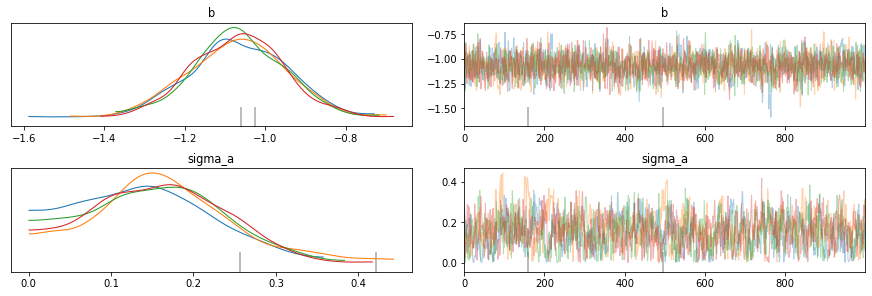

In [140]:
arviz.plot_trace(inference_data, var_names=["b", "sigma_a"]);

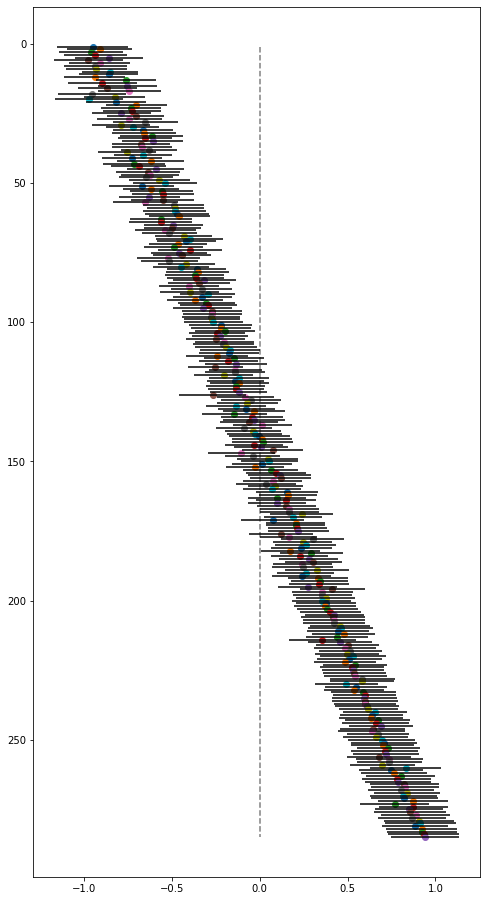

In [66]:
fig, ax = plt.subplots(figsize=(8, 16))

for i in range(num_players):
    a_mean = params["a"][:, i].mean()
    a_sd = float(summary_df.loc[summary_df["parameter"] == f"a[{i}]", "sd"])
    ax.scatter(a_mean, i + 1)
    ax.hlines(i + 1, a_mean - a_sd, a_mean + a_sd)
    
plt.vlines(0, 1, num_players, linestyle="--", alpha=0.5);
plt.gca().invert_yaxis();

In [74]:
summary_df

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,b,-1.068,0.116,-1.287,-0.852,0.002,0.002,2274.0,2227.0,2299.0,2565.0,1.00
1,sigma_a,0.153,0.080,0.000,0.282,0.003,0.002,630.0,630.0,625.0,1100.0,1.01
2,raw_a[0],-0.158,1.000,-2.150,1.650,0.013,0.018,5754.0,1567.0,5747.0,2944.0,1.00
3,raw_a[1],0.023,0.953,-1.732,1.833,0.013,0.016,5809.0,1702.0,5792.0,2564.0,1.00
4,raw_a[2],-0.274,0.876,-1.837,1.422,0.013,0.014,4506.0,1982.0,4474.0,2770.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2256,ypred[1682],1.952,0.660,1.000,3.000,0.011,0.007,3900.0,3871.0,3899.0,3607.0,1.00
2257,ypred[1683],1.937,0.664,1.000,3.000,0.010,0.007,4084.0,4084.0,4084.0,4000.0,1.00
2258,ypred[1684],1.941,0.662,1.000,3.000,0.010,0.007,4114.0,4114.0,4115.0,3878.0,1.00
2259,ypred[1685],1.958,0.652,1.000,3.000,0.010,0.007,4057.0,4057.0,4058.0,3961.0,1.00


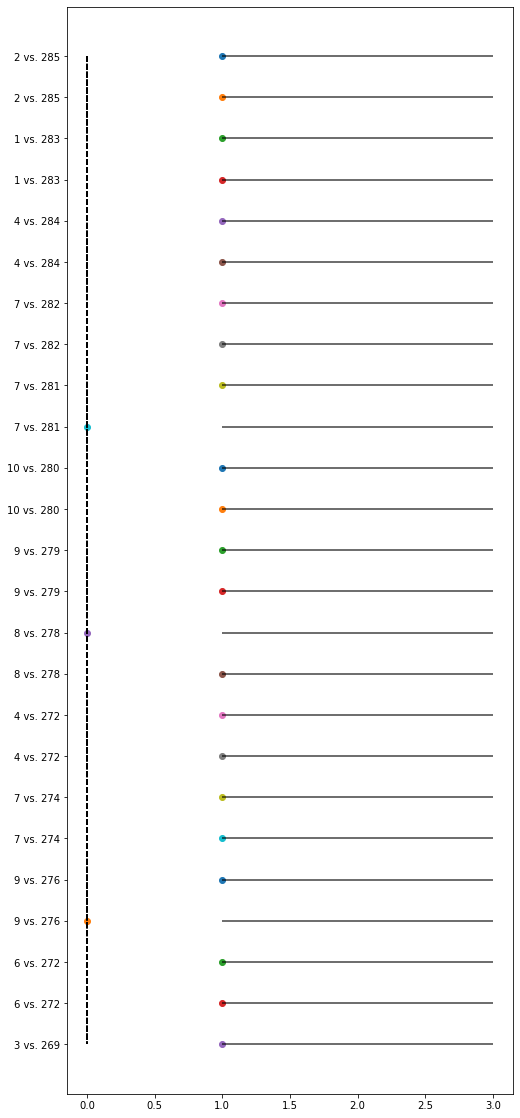

In [78]:
q = 0.95
plot_n = 25
reverse = False

plot_df = train_sorted if not reverse else train_sorted.sort_values(["abs_rank_diff", "fave_id"], ascending=[True, False])
#games = [f"{a} vs. {b}" for a, b in zip(train_sorted["fave_id"].values.astype(int), train_sorted["underdog_id"].values.astype(int))]
ranks = [f"{a} vs. {b}" for a, b in zip(train_sorted["fave_rank"].values.astype(int), train_sorted["underdog_rank"].values.astype(int))]

fig, ax = plt.subplots(figsize=(8, 20))
for i in range(plot_n):
    lq, uq = np.quantile(params["ypred"][:, i], q=[(1-q)/2, q + (1-q)/2])
    ax.scatter(train_sorted["fave_underdog_score_diff"].values[i], i+1)
    #ax.scatter(train_sorted["fave_outcome"].values[i], i+1)
    ax.hlines(i + 1, lq, uq, alpha=0.75)
    ax.vlines(0, 1, plot_n, linestyle="--", alpha=0.5)
plt.gca().invert_yaxis();
#plt.xlim(-2, 2);
if not reverse:
    plt.yticks(range(1, plot_n + 1), ranks[:plot_n]);
else:
    plt.yticks(range(1, plot_n + 1), ranks[-plot_n:]);

### Ordinal plot

Outcome 1 is the favourite won.

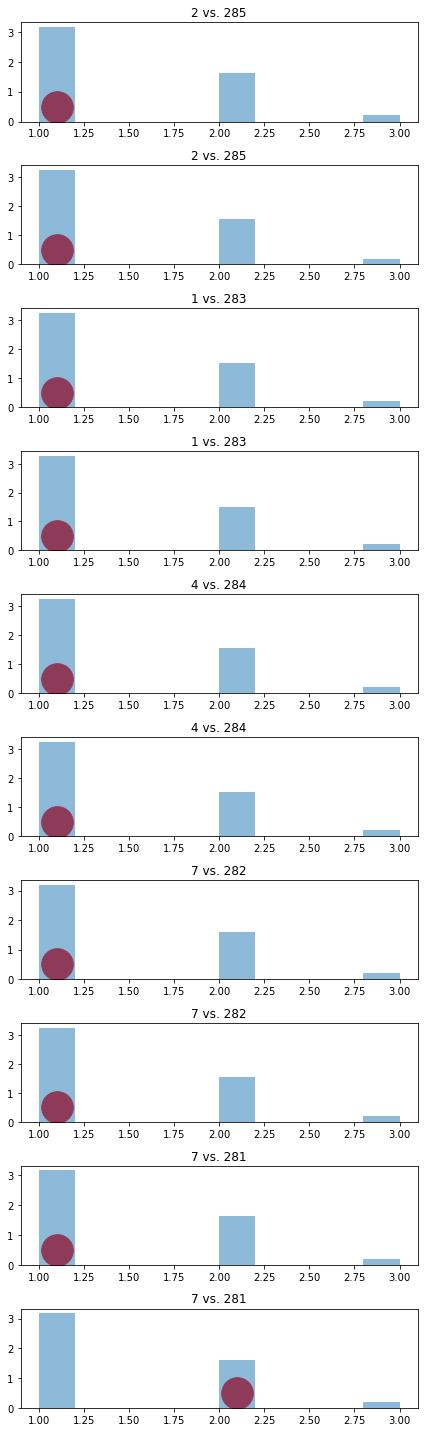

In [118]:
plot_n = 10
reverse = False

plot_df = train_sorted if not reverse else train_sorted.sort_values(["abs_rank_diff", "fave_id"], ascending=[True, False])
#games = [f"{a} vs. {b}" for a, b in zip(train_sorted["fave_id"].values.astype(int), train_sorted["underdog_id"].values.astype(int))]
ranks = [f"{a} vs. {b}" for a, b in zip(train_sorted["fave_rank"].values.astype(int), train_sorted["underdog_rank"].values.astype(int))]

fig, ax = plt.subplots(plot_n, 1, figsize=(6, 20))
ax = ax.ravel()

for i in range(plot_n):
    ax[i].scatter(train_sorted["fave_outcome"].values[i]+0.1, 0.5, color="red", s=1000)
    ax[i].hist(params["ypred"][:, i], alpha=0.5, density=True);
    ax[i].set_title(f"{ranks[i]}")
plt.tight_layout();
#plt.gca().invert_yaxis();
#plt.xlim(-2, 2);
# if not reverse:
#     plt.yticks(range(1, plot_n + 1), ranks[:plot_n]);
# else:
#plt.yticks(range(1, plot_n + 1), ranks[:plot_n]);

In [132]:
preds = []
for i in range(num_games):
    _, counts = np.unique(params["ypred"][:, i],return_counts=True)
    preds.append(np.argmax(counts)+1)
preds = np.array(preds)

In [133]:
train_sorted["pred_class"] = preds

In [136]:
train_sorted.tail(25)

,date,round,white_id,black_id,white_elo,black_elo,white_title,black_title,result,white_score,...,fave_id,underdog_id,fave_rank,underdog_rank,fave_score,underdog_score,fave_outcome,abs_rank_diff,fave_underdog_score_diff,pred_class
1210,2015-09-18,3.2,4102142,13400924,2727.0,2738.0,GM,GM,1/2-1/2,0.5,...,4102142.0,13400924.0,20.0,21.0,0.5,0.5,2,1,0.0,2
1217,2015-09-19,3.3,13400924,4102142,2738.0,2727.0,GM,GM,1/2-1/2,0.5,...,4102142.0,13400924.0,20.0,21.0,0.5,0.5,2,1,0.0,2
1224,2015-09-19,3.4,4102142,13400924,2727.0,2738.0,GM,GM,1-0,1.0,...,4102142.0,13400924.0,20.0,21.0,1.0,0.0,1,1,1.0,2
1624,2013-08-17,3.1,4102142,13400924,2746.0,2733.0,GM,GM,1-0,1.0,...,4102142.0,13400924.0,20.0,21.0,1.0,0.0,1,1,1.0,2
1640,2013-08-18,3.2,13400924,4102142,2733.0,2746.0,GM,GM,1/2-1/2,0.5,...,4102142.0,13400924.0,20.0,21.0,0.5,0.5,2,1,0.0,2
1627,2013-08-17,3.1,4152956,4116992,2719.0,2739.0,GM,GM,1/2-1/2,0.5,...,4116992.0,4152956.0,25.0,26.0,0.5,0.5,2,1,0.0,2
1643,2013-08-18,3.2,4116992,4152956,2739.0,2719.0,GM,GM,1/2-1/2,0.5,...,4116992.0,4152956.0,25.0,26.0,0.5,0.5,2,1,0.0,2
1653,2013-08-19,3.3,4152956,4116992,2719.0,2739.0,GM,GM,1/2-1/2,0.5,...,4116992.0,4152956.0,25.0,26.0,0.5,0.5,2,1,0.0,2
1663,2013-08-19,3.4,4116992,4152956,2739.0,2719.0,GM,GM,1/2-1/2,0.5,...,4116992.0,4152956.0,25.0,26.0,0.5,0.5,2,1,0.0,2
1666,2013-08-19,3.5,4116992,4152956,2739.0,2719.0,GM,GM,1/2-1/2,0.5,...,4116992.0,4152956.0,25.0,26.0,0.5,0.5,2,1,0.0,2


In [139]:
mask = train_sorted["fave_outcome"] == train_sorted["pred_class"]
train_sorted.loc[~mask, :].head(25)

,date,round,white_id,black_id,white_elo,black_elo,white_title,black_title,result,white_score,...,fave_id,underdog_id,fave_rank,underdog_rank,fave_score,underdog_score,fave_outcome,abs_rank_diff,fave_underdog_score_diff,pred_class
1357,2013-08-12,1.2,2020009,5040299,2796.0,2340.0,GM,IM,1/2-1/2,0.5,...,2020009.0,5040299.0,7.0,281.0,0.5,0.5,2,274,0.0,1
868,2015-09-11,1.1,10000100,24116068,2357.0,2798.0,IM,GM,1/2-1/2,0.5,...,24116068.0,10000100.0,8.0,278.0,0.5,0.5,2,270,0.0,1
1359,2013-08-12,1.2,8100977,14109603,2371.0,2772.0,IM,GM,1/2-1/2,0.5,...,14109603.0,8100977.0,9.0,276.0,0.5,0.5,2,267,0.0,1
870,2015-09-11,1.1,4126025,14001128,2774.0,2428.0,GM,IM,1/2-1/2,0.5,...,4126025.0,14001128.0,10.0,273.0,0.5,0.5,2,263,0.0,1
933,2015-09-12,1.2,14001128,4126025,2428.0,2774.0,IM,GM,1/2-1/2,0.5,...,4126025.0,14001128.0,10.0,273.0,0.5,0.5,2,263,0.0,1
991,2015-09-13,1.3,4126025,14001128,2774.0,2428.0,GM,IM,1/2-1/2,0.5,...,4126025.0,14001128.0,10.0,273.0,0.5,0.5,2,263,0.0,1
1015,2015-09-13,1.4,14001128,4126025,2428.0,2774.0,IM,GM,1/2-1/2,0.5,...,4126025.0,14001128.0,10.0,273.0,0.5,0.5,2,263,0.0,1
1039,2015-09-13,1.5,14001128,4126025,2428.0,2774.0,IM,GM,1/2-1/2,0.5,...,4126025.0,14001128.0,10.0,273.0,0.5,0.5,2,263,0.0,1
1046,2015-09-13,1.6,4126025,14001128,2774.0,2428.0,GM,IM,1/2-1/2,0.5,...,4126025.0,14001128.0,10.0,273.0,0.5,0.5,2,263,0.0,1
497,2017-09-04,1.2,5202213,4400704,2792.0,2377.0,GM,IM,1/2-1/2,0.5,...,5202213.0,4400704.0,16.0,275.0,0.5,0.5,2,259,0.0,1
